#### Реализация подсчета Дистанции Левенштейна для русского словаря
Работу выполнил студент Голев. А.С. 2022</br>
 @author: goliksim

In [1]:
%matplotlib inline
import numpy as np
import io
import requests
from tqdm import tqdm
import pandas as pd
import time
from matplotlib import pyplot as plt

Грузим русский словарь

In [2]:
response = requests.get('https://raw.githubusercontent.com/danakt/russian-words/master/russian.txt')

text = response.content.decode('cp1251')

with open('russian.txt', 'wb') as ru:
    ru.write("\n".join(text.upper().split('\n')[100::1500]).encode('utf-8'))

### Метрика Левенштейна

Задание весов для операций

In [3]:
def lvs_distance(string1, string2, ins = 1, deL = 1, sub = 1):
    D = np.zeros((len(string2)+1,len(string1)+1),dtype = int)
    D[:,0] = np.array([i*deL for i in range(len(string2)+1)])
    D[0,:] = np.array([i*ins for i in range(len(string1)+1)])
    for i in range(1,(len(string2)+1)):
        for j in range(1,(len(string1)+1)):
            D[i,j] = min([ D[i-1,j-1]+sub*int(string1[j-1]!=string2[i-1]), D[i-1,j] + deL, D[i,j-1] + ins ])
    return D[-1,-1]

#### Метрика Хэмминга (Евклидово расстояние для слов)

In [4]:
def evl_distance(string1, string2):
    difference = 0
    if len(string1) > len(string2):
        difference = len(string1) - len(string2)
        string1 = string1[:len(string2)]

    elif len(string2) > len(string1):
        difference = len(string2) - len(string1)
        string2 = string2[:len(string1)]
        
    for i in range(len(string1)):
        if string1[i] != string2[i]:
            difference += 1

    return difference

#### Без массива


In [ ]:
lvs_read_array = a = np.array([])
i=1
with io.open('russian.txt', encoding='utf-8') as ru1:
    with io.open('russian.txt', encoding='utf-8') as ru2:
        for words1 in tqdm(ru1):
            ru2.seek(0)
            # скипаем те, что уже проверены
            for _ in range(i):
                next(ru2)
            for words2 in ru2:
                lvs_array = np.append(lvs_array,lvs_distance(words1,words2))
            i+=1


#### Вычисляем дистанции

In [8]:
distances = pd.DataFrame(columns=[
    '1st word', '2nd word','lvs_111','lvs_221','lvs_112','evl', 'lvs_time', 'evl_time'])

In [9]:
with io.open('russian.txt', encoding='utf-8') as ru1:
    ru1 = ru1.read().splitlines()
    
    for i in tqdm(range(len(ru1))):
        for j in range(i+1,len(ru1)):

            start = time.perf_counter()
            lvs_range = lvs_distance(ru1[i],ru1[j])
            end = time.perf_counter()
            lvs_time = float(end - start)

            start = time.perf_counter()
            evl_range = evl_distance(ru1[i],ru1[j])
            end = time.perf_counter()
            evl_time = float(end - start)

            distances.loc[len(distances)] = [ru1[i] ,ru1[j] ,lvs_range, lvs_distance(ru1[i],ru1[j],2,2,1), lvs_distance(ru1[i],ru1[j],1,1,2), evl_range, lvs_time, evl_time]

100%|██████████| 1022/1022 [2:00:26<00:00,  7.07s/it] 


Вывод самых похожих слов в алфавите

In [13]:
def group_distaces(distances, column, n):
     lvs_grouped = distances.groupby([column])

     for (key,group),i in zip(lvs_grouped,range(n)):        
          samples = 1
          if (type(key)==type(1)): samples = 3
          display(lvs_grouped.get_group(key)[['1st word','2nd word',column]].sample(n=samples).reset_index(drop=True))

In [14]:
group_distaces(distances,'lvs_111', 3)

,1st word,2nd word,lvs_111
0,УМЕЮ,ШМЕЛЮ,2
1,СЖИГАЙТЕ,УЖИНАЙТЕ,2
2,ОСТОВЫЙ,СОСКОВЫЙ,2


,1st word,2nd word,lvs_111
0,ВКОПАЛСЯ,ВПИВАЛСЯ,3
1,ОТКОЛЕМ,ОТКРОЕТ,3
2,ДЕЧНОЙ,РУЧНОМ,3


,1st word,2nd word,lvs_111
0,ДУГОВОЕ,ТУГОДУМЕ,4
1,БРАНОЮ,КРАПУ,4
2,ТОЛЬК,ХОЛИШЬ,4


In [15]:
group_distaces(distances,'evl',3)

,1st word,2nd word,evl
0,КРАПУ,КРАЮ,2
1,СЖИГАЙТЕ,УЖИНАЙТЕ,2
2,ОЖИГАЕТЕ,СЖИГАЙТЕ,2


,1st word,2nd word,evl
0,ДЕЧНОЙ,КАЗНОЙ,3
1,ПОИМЕНУЮ,ПОЛЮСНУЮ,3
2,ВУЗКОМ,РУЧНОМ,3


,1st word,2nd word,evl
0,НЕМАЛЫМИ,ПЕРИЛАМИ,4
1,ГИФАМ,МИРЯТ,4
2,ЛЮТОЕ,СУРОВ,4


#### Корреляция дистанций Левенштейна c Евклидовой метрикой

In [16]:
def calc_corr(distances):
    display(distances[['lvs_111','lvs_221','lvs_112','evl']].corr())

In [17]:
calc_corr(distances)

,lvs_111,lvs_221,lvs_112,evl
lvs_111,1.000000,0.869222,0.861508,0.897051
lvs_221,0.869222,1.000000,0.590392,0.870369
lvs_112,0.861508,0.590392,1.000000,0.732565
evl,0.897051,0.870369,0.732565,1.000000


#### Выведем какие-нибудь слова и посмотрим на дистанции

In [18]:
def show_samples(distances):
    display(distances.sample(n = 10)[['1st word', '2nd word','lvs_111','lvs_221','lvs_112','evl']])

In [19]:
show_samples(distances)

,1st word,2nd word,lvs_111,lvs_221,lvs_112,evl
234199,ЗВЕНОРАЗБОРОЧНЫХ,МЯГКОТЕЛКУ,15,21,24,15
473184,ПРОБОЙНОМ,ЧЕТЫРЁХСТЕННОМ,10,15,15,14
293500,ЛАРЕЧНИКИ,УМЕЮ,8,13,11,9
317814,МНОГОПОЛЬНОЙ,УПРАШИВАВШЕМУ,13,14,23,13
380257,ОЗИРАВШИЙ,РЕЖИМОМ,9,11,12,9
515654,ТОРМОШИ,УЛЬЧСКИМИ,8,10,12,8
134316,ГАЛОШНИЦ,МАРШАХ,6,8,10,7
116080,ВЫЛЕПЛЕННОМУ,СВОДНИЧАЕТЕ,12,13,17,12
112637,ВЫЗВАВШЕМСЯ,ЧЕРНИЧНИКОМ,11,11,18,11
186686,ДЯТЛОВОЮ,УРОНЕН,7,9,12,8


#### Посмотрим на время

In [20]:
time_plot =  distances.astype({'lvs_time': float,'evl_time': float}).loc[distances['1st word'].apply(len) == distances['2nd word'].apply(len)].groupby(distances['1st word'].apply(len)).mean()

C:\Users\golev\AppData\Local\Temp\ipykernel_23836\2752912882.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


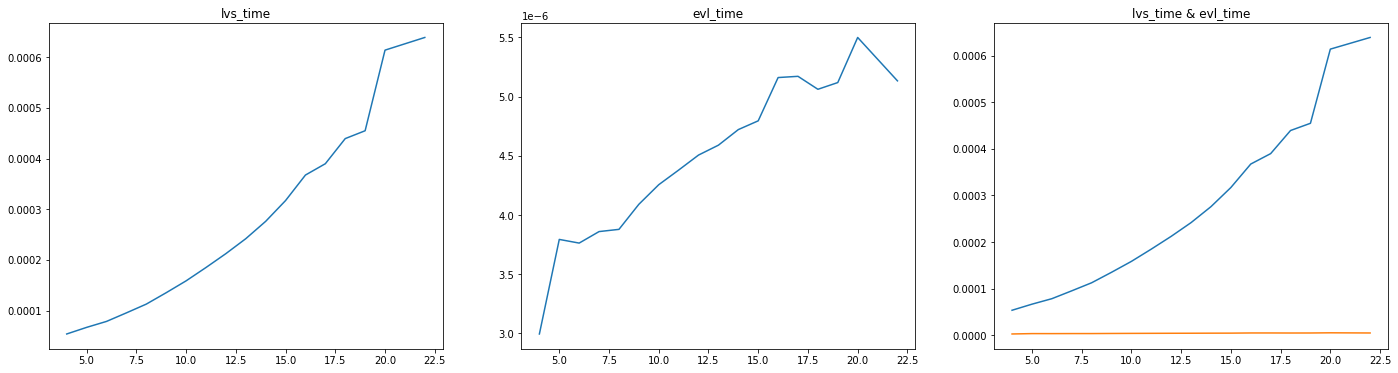

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(24,6))
ax[0].plot(time_plot[['lvs_time']])
ax[0].set_title('lvs_time')
ax[1].plot(time_plot[['evl_time']])
ax[1].set_title('evl_time')
ax[2].plot(time_plot[['lvs_time','evl_time']])
ax[2].set_title('lvs_time & evl_time')
fig.show()

## Теперь поработаем с окончаниями
Нужно выбрать какую-нибудь функцию, понижающую вес в зависимости от близости к концу слова

In [37]:
def increase_weight(x, size):
    return 1-0.8*(x/20)

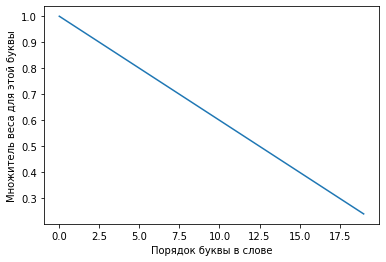

In [38]:

x = np.linspace(0,19,20)
y = increase_weight(x, len(x))

plt.plot(x,y)
plt.xlabel("Порядок буквы в слове")
plt.ylabel("Множитель веса для этой буквы")
plt.show()

In [39]:
def lvs_end_distance(string1, string2,max_len, ins = 1, deL = 1, sub = 1):
    D = np.zeros((len(string2)+1,len(string1)+1),dtype = float)
    D[:,0] = np.array([i*deL*increase_weight(i,max_len+1+1) for i in range(len(string2)+1)])
    D[0,:] = np.array([i*ins*increase_weight(i,max_len+1+1) for i in range(len(string1)+1)])
    for i in range(1,(len(string2)+1)):
        for j in range(1,(len(string1)+1)):
            ins_weight = ins*increase_weight(i,max_len+1)
            del_weight = deL*increase_weight(i,max_len+1)
            sub_weight =  sub*int(string1[j-1]!=string2[i-1])*increase_weight(i,max_len+1)
            if i<=j:
                ins_weight = ins*increase_weight(j,max_len+1)
                del_weight = deL*increase_weight(j,max_len+1)
                sub_weight =  sub*int(string1[j-1]!=string2[i-1])*increase_weight(i,max_len+1)
            
            D[i,j] = min([ D[i-1,j-1] + sub_weight, D[i-1,j] + del_weight, D[i,j-1] + ins_weight ])
            #СДЕЛАТЬ РАЗНИЦУ В ДИАГОНАЛЬНОМ ЗАПОЛНЕНИИ
    return D[-1,-1]

In [ ]:
lvs_end_distance('АЛМАASDAS','АЛМАASDAA',20)	

#### Вычисляем дистанции с окончаниями

In [40]:
end_distances = pd.DataFrame(columns=[
    '1st word', '2nd word','lvs_111','lvs_221','lvs_112','evl'])

In [41]:
with io.open('russian.txt', encoding='utf-8') as ru1:
    ru1 = ru1.read().splitlines()
    max_len = len(max(ru1, key = (lambda x: len(x))))
    for i in tqdm(range(len(ru1))):
        for j in range(i+1,len(ru1)):
            lvs_range = lvs_end_distance(ru1[i],ru1[j],max_len)
            evl_range = evl_distance(ru1[i],ru1[j])       
            end_distances.loc[len(end_distances)] = [ru1[i] ,ru1[j] ,lvs_range, lvs_end_distance(ru1[i],ru1[j],max_len,2,2,1), lvs_end_distance(ru1[i],ru1[j],max_len,1,1,2), evl_range]

100%|██████████| 1022/1022 [1:59:48<00:00,  7.03s/it] 


In [42]:
end_distances.describe()

,lvs_111,lvs_221,lvs_112,evl
count,521731.000000,521731.000000,521731.000000,521731.000000
mean,7.545278,9.859818,9.717884,11.975068
std,1.151272,2.123446,1.382243,2.760214
min,1.320000,1.680000,2.200000,2.000000
25%,6.840000,8.360000,8.920000,10.000000
50%,7.680000,9.720000,9.880000,12.000000
75%,8.360000,11.280000,10.720000,14.000000
max,10.560000,16.000000,12.480000,22.000000


Вывод самых похожих слов в алфавите

In [43]:
group_distaces(end_distances,'lvs_111',7)

,1st word,2nd word,lvs_111
0,ДЕВЯТИЭТАЖНЫМ,ДЕСЯТИЭТАЖНЫМИ,1.32


,1st word,2nd word,lvs_111
0,СПРАШИВАВШЕМ,УПРАШИВАВШЕМУ,1.44


,1st word,2nd word,lvs_111
0,КРАПУ,КРАЮ,1.64


,1st word,2nd word,lvs_111
0,НАКАЛЕННОЙ,НАЛАЖЕННОЙ,1.68


,1st word,2nd word,lvs_111
0,ОЖИГАЕТЕ,СЖИГАЙТЕ,1.72


,1st word,2nd word,lvs_111
0,КАРАТ,КРАЮ,1.76


,1st word,2nd word,lvs_111
0,СЖИГАЙТЕ,УЖИНАЙТЕ,1.8


#### Корреляция дистанций Левенштейна c Евклидовой метрикой

In [44]:
calc_corr(end_distances)

,lvs_111,lvs_221,lvs_112,evl
lvs_111,1.000000,0.636238,0.540500,0.532690
lvs_221,0.636238,1.000000,-0.156279,0.745719
lvs_112,0.540500,-0.156279,1.000000,-0.118626
evl,0.532690,0.745719,-0.118626,1.000000


#### Выведем какие-нибудь слова и посмотрим на дистанции

In [45]:
show_samples(end_distances)

,1st word,2nd word,lvs_111,lvs_221,lvs_112,evl
413665,ПЕДЕЛЬ,СКАНДАЛИТ,5.64,8.04,8.52,9
223939,ЗАСМАТРИВАЮЩИЙ,СКАНДАЛИТ,7.60,11.28,10.08,13
379973,ОЗИРАВШИЙ,ОСРАМИВШИСЬ,4.52,6.68,5.96,10
252397,ИНФИНИТЕЗИМАЛЬНОЕ,ПРИСКУЧИВАВШИЙ,9.48,11.32,9.92,17
230986,ЗАХЛЁСТЫВАВШЕЙСЯ,ХРЯСНУВШИМ,8.36,12.12,9.32,16
413323,ПАУТИНИСТОМ,ФАБРЕНА,6.68,9.16,10.08,9
497147,РЕХНУТСЯ,ФОТОХРОМНОЕ,7.52,9.84,9.96,11
277276,КОННИКАМ,ОТДАВАВШЕЕ,7.04,9.04,10.40,10
284063,КРАПУ,МЕДИАПЛЕЕРОВ,7.28,12.04,8.84,12
196037,ЗАВАРКУ,ПАНАГИЮ,4.12,4.12,8.12,5


Что нужно сделать:
1. Самые похожие слова вывести - метрика (показать) сколько то пар слов + окончания
2. Для каких то пар слов вывести веса при разных распределениях   + окончания 
3. Время от длины слов (фиксированные словари) и посчитатать среднее время. Графии среднее время в зависимости от длинны слова 
<br/>
Для окончаний уменьшать вес в зависимости от положения символа